In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!unzip '/content/drive/My Drive/train_prepared.zip'

Archive:  /content/drive/My Drive/train_prepared.zip
   creating: train_prepared/
  inflating: train_prepared/0.jpeg   
  inflating: train_prepared/1.jpeg   
  inflating: train_prepared/100.jpeg  
  inflating: train_prepared/1000.jpeg  
  inflating: train_prepared/1001.jpeg  
  inflating: train_prepared/1002.jpeg  
  inflating: train_prepared/1003.jpeg  
  inflating: train_prepared/1004.jpeg  
  inflating: train_prepared/1005.jpeg  
  inflating: train_prepared/1006.jpeg  
  inflating: train_prepared/1007.jpeg  
  inflating: train_prepared/1008.jpeg  
  inflating: train_prepared/1009.jpeg  
  inflating: train_prepared/101.jpeg  
  inflating: train_prepared/1010.jpeg  
  inflating: train_prepared/1011.jpeg  
  inflating: train_prepared/1012.jpeg  
  inflating: train_prepared/1013.jpeg  
  inflating: train_prepared/1014.jpeg  
  inflating: train_prepared/1015.jpeg  
  inflating: train_prepared/1016.jpeg  
  inflating: train_prepared/1017.jpeg  
  inflating: train_prepared/1018.jpeg  
  in

In [ ]:
!unzip '/content/drive/My Drive/test_prepared.zip'

Archive:  /content/drive/My Drive/test_prepared.zip
   creating: test_prepared/
  inflating: test_prepared/0.jpeg    
  inflating: test_prepared/1.jpeg    
  inflating: test_prepared/10.jpeg   
  inflating: test_prepared/100.jpeg  
  inflating: test_prepared/1000.jpeg  
  inflating: test_prepared/1001.jpeg  
  inflating: test_prepared/1002.jpeg  
  inflating: test_prepared/1003.jpeg  
  inflating: test_prepared/1004.jpeg  
  inflating: test_prepared/1005.jpeg  
  inflating: test_prepared/1006.jpeg  
  inflating: test_prepared/1007.jpeg  
  inflating: test_prepared/1008.jpeg  
  inflating: test_prepared/1009.jpeg  
  inflating: test_prepared/101.jpeg  
  inflating: test_prepared/1010.jpeg  
  inflating: test_prepared/1011.jpeg  
  inflating: test_prepared/1012.jpeg  
  inflating: test_prepared/1013.jpeg  
  inflating: test_prepared/1015.jpeg  
  inflating: test_prepared/1016.jpeg  
  inflating: test_prepared/1017.jpeg  
  inflating: test_prepared/1018.jpeg  
  inflating: test_prepared/1

In [ ]:
train_val_labels = pd.read_csv('train_prepared/train.csv')

In [ ]:
train_val_labels.sort_values(by='filename', inplace=True)

In [ ]:
train_val_labels = train_val_labels.label.values

In [ ]:
RESCALE_SIZE = 70

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, files, labels):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # список меток классов
        self.labels = labels

        self.len_ = len(self.files)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        y = self.labels[index]
        return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
TRAIN_DIR = Path('./train_prepared')
# TEST_DIR = Path('data/test_data')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
# test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))

In [ ]:
train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels, test_size=0.15)

In [ ]:
val_dataset = CustomDataset(val_files, val_labels.ravel())
train_dataset = CustomDataset(train_files, train_labels.ravel())
# test_dataset = CustomDataset(test_files, test_labels.ravel())

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

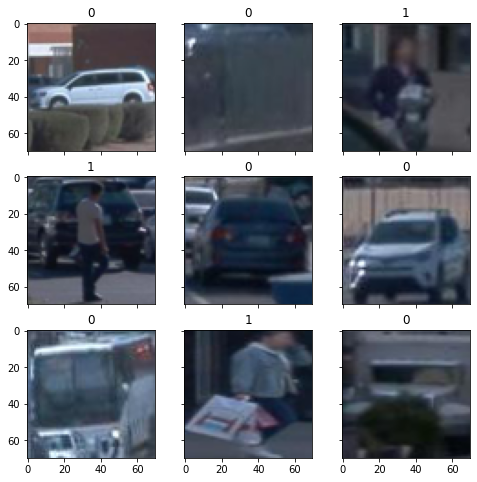

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_dataset)))
    im_val, img_label = val_dataset[random_characters]
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

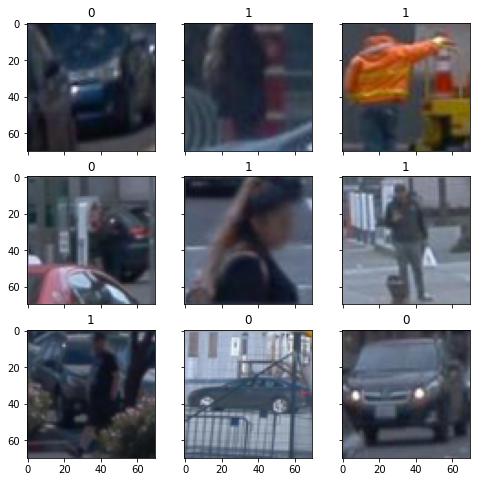

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(train_dataset)))
    im_val, img_label = train_dataset[random_characters]
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3)
        self.fc1 = nn.Linear(16 * 16 * 6, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 16 * 16 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
!nvidia-smi

Wed Oct 28 12:05:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    31W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def train(epochs, train_loader, val_loader, device, optimizer, loss_fn, model):
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    pbar = tqdm(range(epochs), desc=f"Epoch {1}. Train Loss: {0} Val loss: {0}")
    for epoch in pbar:
        model.train()
        
        train_epoch_losses = []
        val_epoch_losses = []
        train_epoch_accuracy = []
        val_epoch_accuracy = []
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_epoch_losses.append(loss.item())

            _, predicted = torch.max(y_pred, 1)

            c = (predicted == y_batch)
            train_epoch_accuracy.append(c.sum().item()/len(c))
        
        train_losses.append(np.mean(train_epoch_losses))
        train_accuracy.append(np.mean(train_epoch_accuracy))

        model.eval()

        for batch in val_loader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            val_epoch_losses.append(loss.item())

            _, predicted = torch.max(y_pred, 1)

            c = (predicted == y_batch)
            val_epoch_accuracy.append(c.sum().item()/len(c))
        
        val_losses.append(np.mean(val_epoch_losses))
        val_accuracy.append(np.mean(val_epoch_accuracy))

        pbar.set_description(f"Epoch {epoch + 1}. Train Loss: {np.mean(train_epoch_losses):.4} Val Loss: {np.mean(val_epoch_losses):.4}")

    print('Обучение закончено')
    return train_losses, train_accuracy, val_losses, val_accuracy

In [ ]:
net = SimpleConvNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
train_losses, train_accuracy, val_losses, val_accuracy = train(10, train_loader,val_loader, device, optimizer, loss_fn, net)


Обучение закончено


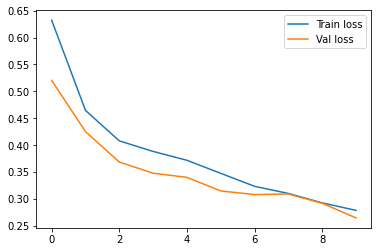

In [ ]:
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label = 'Val loss')
plt.legend()

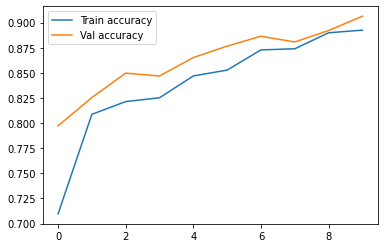

In [ ]:
plt.plot(train_accuracy, label='Train accuracy')
plt.plot(val_accuracy, label = 'Val accuracy')
plt.legend()

In [ ]:
net.eval()
accuracies = []
for batch in val_loader:
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = net(X_batch)

    _, predicted = torch.max(y_pred, 1)

    c = (predicted == y_batch)
    accuracies.append(c.sum().item()/len(c))

In [ ]:
np.mean(accuracies)

0.90625


FOLD 1



Обучение закончено


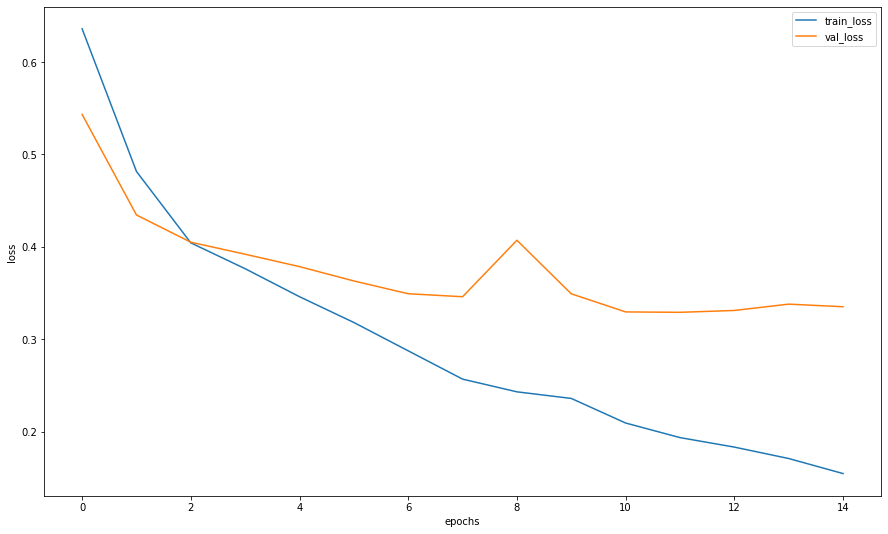


FOLD 2



Обучение закончено


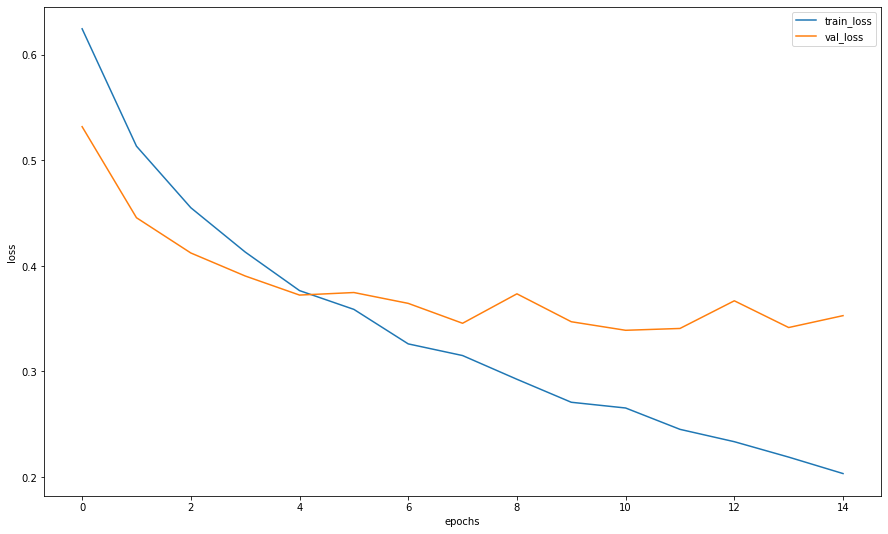


FOLD 3



Обучение закончено


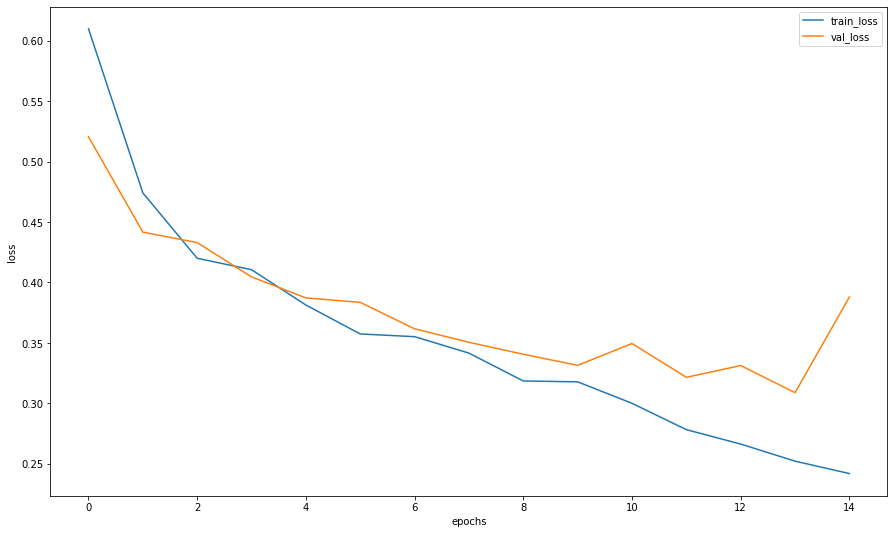


FOLD 4



Обучение закончено


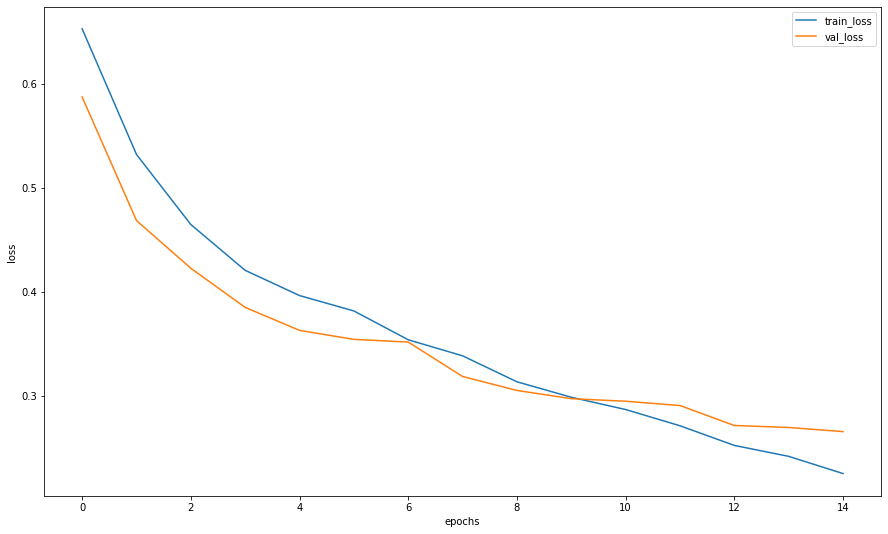


FOLD 5



Обучение закончено


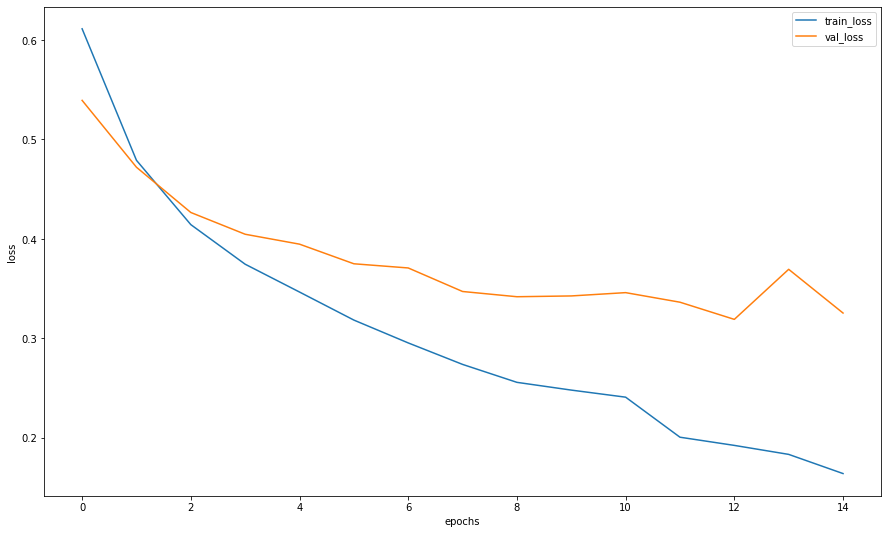

In [ ]:
from sklearn.model_selection import StratifiedKFold
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
accuracies = []
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, train_val_labels)):
    print('\nFOLD', fold+1)
    train_dataset = CustomDataset(np.array(train_val_files)[train_idx], train_val_labels[train_idx])
    val_dataset = CustomDataset(np.array(train_val_files)[val_idx], train_val_labels[val_idx])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    net = SimpleConvNet().to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    loss, acc, val_loss, val_acc = train(15, train_loader,val_loader, device, optimizer, loss_fn, net)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()

    accuracies.append(val_acc)

In [ ]:
np.mean(accuracies)

0.8489625850340137